HHU Deep Learning, SS2025, Prof. Dr. Markus Kollmann

Tutoring is done by Nikolas Adaloglou and Felix Michels.

# Assignment 01 - Representation Learning with AutoEncoders

---

Submit the solved notebook (not a zip) with your full name plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise and submitted code for each task, you will receive 1 point for this assignment, regardless of the quality of your solution.

If you cannot proceed past some part you need to ask on RocketChat ahead of the deadline.


## <center> DUE FRIDAY 25.04.2024 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/UTrFcW2xJVbV4XO](https://uni-duesseldorf.sciebo.de/s/UTrFcW2xJVbV4XO)

---



## Introduction to Autoencoders

An autoencoder (AE) is a neural network that learns to reconstruct its input data by compressing the input into a lower-dimensional representation, which is called a **bottleneck** or latent representation. The basic architecture of an autoencoder consists of two main components: an encoder and a decoder. The encoder takes the input data and maps it to the bottleneck representation. The decoder then takes this bottleneck representation and maps it back to the original input space.

During training, the autoencoder tries to minimize the reconstruction loss between the original input and the reconstructed output. The weights of the encoder and decoder are adjusted during training to minimize this reconstruction error. By minimizing the reconstruction loss, the autoencoder learns to compress the input data into a lower-dimensional representation while preserving the essential information.


Autoencoders can be used for representation learning by leveraging the encoder as a feature extractor. The learned features can be more informative and discriminative than the original input data, especially when it has a high dimensionality. Autoencoders can also be used for transfer learning, where the pre-trained encoder can be fine-tuned on a new dataset for a different task.


The learned features can be used for downstream tasks such as classification, clustering, or regression.

In this exercise, we will focus on image classification. The bottleneck representation learned by the autoencoder will be used as a feature vector for a classifier.





# Part I. Basic imports


In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms as T
from tqdm.auto import tqdm, trange
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
torch.set_default_device(device)

# Getting the data


torch.Size([16, 3, 96, 96]) torch.Size([16])
torch.Size([16, 3, 96, 96]) torch.Size([16])


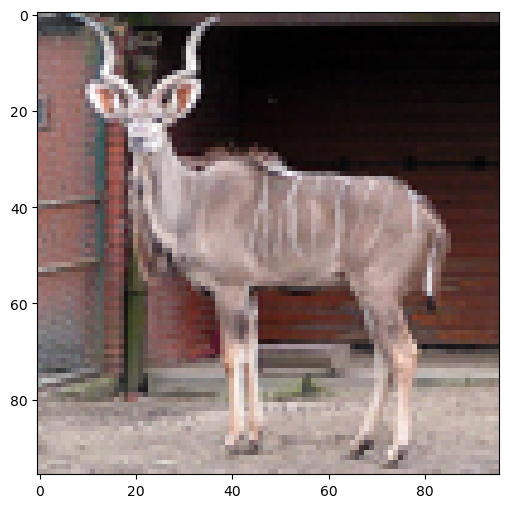

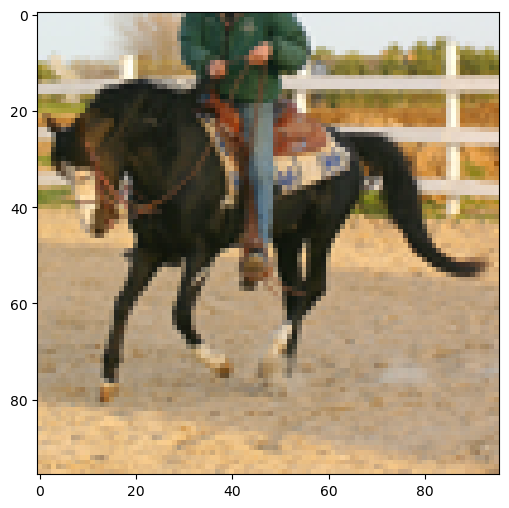

In [2]:
def load_data(batch_size=128, train_split="unlabeled", test_split="test"):
    # Returns a train and validation dataloader for STL10 dataset
    ### START CODE HERE ### (≈ 6 lines of code)
    transform = T.Compose([
        T.ToTensor(),
    ])

    train_ds = torchvision.datasets.STL10(root='../data', split=train_split, download=True, transform=transform)
    val_ds = torchvision.datasets.STL10(root='../data', split=test_split, download=True, transform=transform)

    train_dl = DataLoader(train_ds, batch_size=batch_size)
    val_dl = DataLoader(val_ds, batch_size=batch_size)
    ### END CODE HERE ###
    return train_dl, val_dl


def imshow(img, i=0, mean=torch.tensor([0.0], dtype=torch.float32), std=torch.tensor([1], dtype=torch.float32)):
    """
    shows an image on the screen. mean of 0 and variance of 1 will show the images unchanged in the screen
    """
    # undoes the normalization
    unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    npimg = unnormalize(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


def test_load_data():
    train_dl, val_dl = load_data(batch_size=16)
    for i, (x, y) in enumerate(train_dl):
        print(x.shape, y.shape)
        plt.figure(figsize=(6, 6))
        imshow(x[0, ...])
        break
    for i, (x, y) in enumerate(val_dl):
        print(x.shape, y.shape)
        plt.figure(figsize=(6, 6))
        imshow(x[0, ...])
        break


test_load_data()

# Build the AutoEncoder

- Given in_channels, base_channels, n_layers, kernel_size,stride,padding
- Build a symmetrical autoencoder with convolutions and transpose convolutions.
- For all the intermediate layers, use the ReLU function. Sigmoid for the output.
- Base channels are the out channels of the first conv layer in the encoder.
- Each subsequent encoder layer doubles the channels of the previous.
- Each subsequent decoder layer halves the channels of the previous.
- The implementation should support a varying number of layers (`n_layers`)
- The Conv and Transpose conv take the same kernel size, stride and padding.
- Choose kernel size and padding to halve the feature dimension in the encoder.

#### Hints:
You can use the `layers = nn.ModuleList()` to append the layers and then plug them in `nn.Sequential(*layers)`


In [3]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels, base_channels, n_layers, kernel_size, stride, padding):
        """Builds the autoencoder model

        Args:
            in_channels: number of input channels (3 for RGB images)
            base_channels: number of channels in the first conv layer of the encoder
            n_layers: number of conv/transp_conv layers in the encoder/decoder
            kernel_size: kernel size for the conv/transp_conv layers
            stride: stride for the conv/transp_conv layers
            padding: padding for the conv/transp_conv layers
        """
        super(Autoencoder, self).__init__()
        # Optional to use nn.ModuleList
        enc_layers = nn.ModuleList()
        dec_layers = nn.ModuleList()
        ### START CODE HERE ### (≈ 2 lines of code)
        in_ch, out_ch = in_channels, base_channels
        for i in range(n_layers):
            enc_layers.add_module(f"enc_{i}", nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding))
            enc_layers.add_module(f"enc_relu_{i}", nn.ReLU())
            in_ch, out_ch = out_ch, out_ch * 2

        out_ch //= 2
        for i in range(n_layers - 1):
            dec_layers.add_module(f"dec_{i}", nn.ConvTranspose2d(in_ch, out_ch, kernel_size, stride, padding, output_padding=1))
            dec_layers.add_module(f"dec_relu_{i}", nn.ReLU())
            in_ch, out_ch = out_ch, out_ch // 2

        dec_layers.add_module(f"dec_{n_layers - 1}", nn.ConvTranspose2d(in_ch, in_channels, kernel_size, stride, padding, output_padding=1))
        dec_layers.add_module(f"sig_out", nn.Sigmoid())
        ### END CODE HERE ###
        self.encoder = nn.Sequential(*enc_layers)
        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstruction = self.decoder(bottleneck)
        return reconstruction

    def encode(self, x):
        return self.encoder(x)


def test_Autoencoder():
    base_channels = 4
    n_layers = 4
    autoencoder = Autoencoder(base_channels=base_channels, n_layers=n_layers,
                              in_channels=5, kernel_size=3, stride=2, padding=1)
    x = torch.randn(1, 5, 32, 32)
    reconstruction = autoencoder(x)
    bottleneck = autoencoder.encode(x)
    assert bottleneck.shape == (1, 32, 2, 2), "Bottleneck shape is not correct"
    assert x.shape == reconstruction.shape, "Output shape should be the same as input shape"
    print("Autoencoder test passed!")


test_Autoencoder()

Autoencoder test passed!


# Validate function


First, we will implement the validation function. We will use later it in the train function. The idea is to test our model on the (unseen) validation data in regular intervals during training, e.g. after every epoch (traversal of the whole dataset).

`Exercise`: Implement the validation function, which reads in data from the val_dl, runs a forward pass and records the loss. The validation loop typically follows these steps:
- Set the model to evaluation mode. This is important because it disables any dropout or batch normalization layers, which are used during training but not during inference.
- Iterate through the validation loader.
- For each batch, pass the input data through the model to get the predicted outputs.
- Compare the predicted outputs with the ground-truth labels to calculate a loss value.
- Aggregate the loss values across all batches to get a total validation loss.

In [4]:
@torch.inference_mode()
def validate(model, val_dl, criterion):
    ### START CODE HERE ### (≈ 12 lines of code)
    model.eval()
    val_loss_epoch = 0
    for X, _ in tqdm(val_dl, desc='Validation Batch', leave=False):
        X = X.to(device)
        output = model(X)
        loss = criterion(output, X)
        val_loss_epoch += loss.item()
    ### END CODE HERE ###
    return val_loss_epoch

# Train one epoch function

The training loop typically follows these steps:
- Set the model to training mode.
- Iterate through the training dataset in batches.
- Forward propagation: For each batch, pass the input data through the model to get the predicted outputs.
- Backward propagation: Compute loss function:Calculate the loss value between the predicted outputs and the ground-truth labels using a loss function.
- Calculate the gradients of the loss with respect to the model parameters.
- Update parameters: Update the model parameters based on the gradients.

In [5]:
def train_one_epoch(model, optimizer, train_dl, criterion):
    ### START CODE HERE ### (≈ 12 lines of code)
    model.train()
    loss_curr_epoch = 0
    for X, _ in tqdm(train_dl, desc='Train Batch', leave=False):
        X = X.to(device)
        optimizer.zero_grad()

        output = model(X)
        loss = criterion(output, X)
        loss_curr_epoch += loss.item()

        loss.backward()
        optimizer.step()
    ### END CODE HERE ###
    return loss_curr_epoch

# Train code

Combine train_one_epoch and validation code into a single script.

A dictionary should be returned with the train and validation loss per epoch.

Save the model with the smallest validation loss

In [6]:
def save_model(model, path, epoch, optimizer, val_loss):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
    }, path)


def train(model, optimizer, num_epochs, train_dl, val_dl, criterion):
    dict_log = {"train_loss": [], "val_loss": []}
    ### START CODE HERE ### (≈ 12 lines of code)
    best_val_loss = float('inf')
    for epoch in trange(num_epochs, desc='Epoch'):
        train_loss = train_one_epoch(model, optimizer, train_dl, criterion)
        val_loss = validate(model, val_dl, criterion)

        dict_log["train_loss"].append(train_loss)
        dict_log["val_loss"].append(val_loss)

        print(f"Ep {epoch + 1}/{num_epochs}. Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

        if best_val_loss > val_loss:
            best_val_loss = val_loss
            save_model(model, './best_autoencoder_min_val_loss.pth', epoch, optimizer, val_loss)
    ### END CODE HERE ###
    return dict_log

# Launch training!
Choose the model and hyperparameters and launch the training.
The training should not take more than 1h (26mins with our setup).

In [7]:
### START CODE HERE ###
model = Autoencoder(in_channels=3, base_channels=4, n_layers=4, kernel_size=3, stride=2, padding=1)
train_dl, val_dl = load_data()

train_setup = {
    'model': model,
    'optimizer': torch.optim.Adam(model.parameters(), lr=1e-3),
    'criterion': nn.MSELoss(),
    'num_epochs': 20,
    'train_dl': train_dl,
    'val_dl': val_dl
}

In [8]:
train(**train_setup)
### END CODE HERE ###

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 1/20. Train Loss: 21.9983  Val Loss: 1.0006


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 2/20. Train Loss: 11.7452  Val Loss: 0.9147


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 3/20. Train Loss: 10.8448  Val Loss: 0.8585


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 4/20. Train Loss: 10.3501  Val Loss: 0.8226


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 5/20. Train Loss: 9.8882  Val Loss: 0.7849


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 6/20. Train Loss: 9.3536  Val Loss: 0.6823


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 7/20. Train Loss: 7.3453  Val Loss: 0.5580


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 8/20. Train Loss: 6.7970  Val Loss: 0.5327


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 9/20. Train Loss: 6.5568  Val Loss: 0.5194


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 10/20. Train Loss: 6.3636  Val Loss: 0.5020


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 11/20. Train Loss: 6.1992  Val Loss: 0.4906


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 12/20. Train Loss: 6.0612  Val Loss: 0.4804


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 13/20. Train Loss: 5.9423  Val Loss: 0.4717


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 14/20. Train Loss: 5.8415  Val Loss: 0.4680


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 15/20. Train Loss: 5.7551  Val Loss: 0.4550


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 16/20. Train Loss: 5.6793  Val Loss: 0.4494


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 17/20. Train Loss: 5.6096  Val Loss: 0.4484


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 18/20. Train Loss: 5.5498  Val Loss: 0.4456


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 19/20. Train Loss: 5.4939  Val Loss: 0.4450


Train Batch:   0%|          | 0/782 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Ep 20/20. Train Loss: 5.4443  Val Loss: 0.4318


{'train_loss': [21.9983039656654,
  11.745196412317455,
  10.84481240157038,
  10.350098354741931,
  9.888228717260063,
  9.353632559068501,
  7.345306216739118,
  6.796965463086963,
  6.556800888851285,
  6.363613408524543,
  6.19923991849646,
  6.061219369992614,
  5.94226292334497,
  5.8414988848380744,
  5.755119598004967,
  5.679305971134454,
  5.6096245758235455,
  5.5498239188455045,
  5.493856981862336,
  5.444250409025699],
 'val_loss': [1.000639165751636,
  0.914734497666359,
  0.8585302289575338,
  0.8226488204672933,
  0.7848782055079937,
  0.6823126478120685,
  0.5579544445499778,
  0.5326784197241068,
  0.5193633143790066,
  0.5020392430014908,
  0.4905861993320286,
  0.48043307941406965,
  0.4717335719615221,
  0.46796376584097743,
  0.45499238884076476,
  0.4493923606351018,
  0.44840816408395767,
  0.4456197815015912,
  0.4450313742272556,
  0.4317896733991802]}

### Expected result
Val Loss $\sim 0.003$

# Loading the best model and visualizing reconstructions

Model ./best_autoencoder_min_val_loss.pth is loaded from epoch 19 , loss 0.4317896733991802


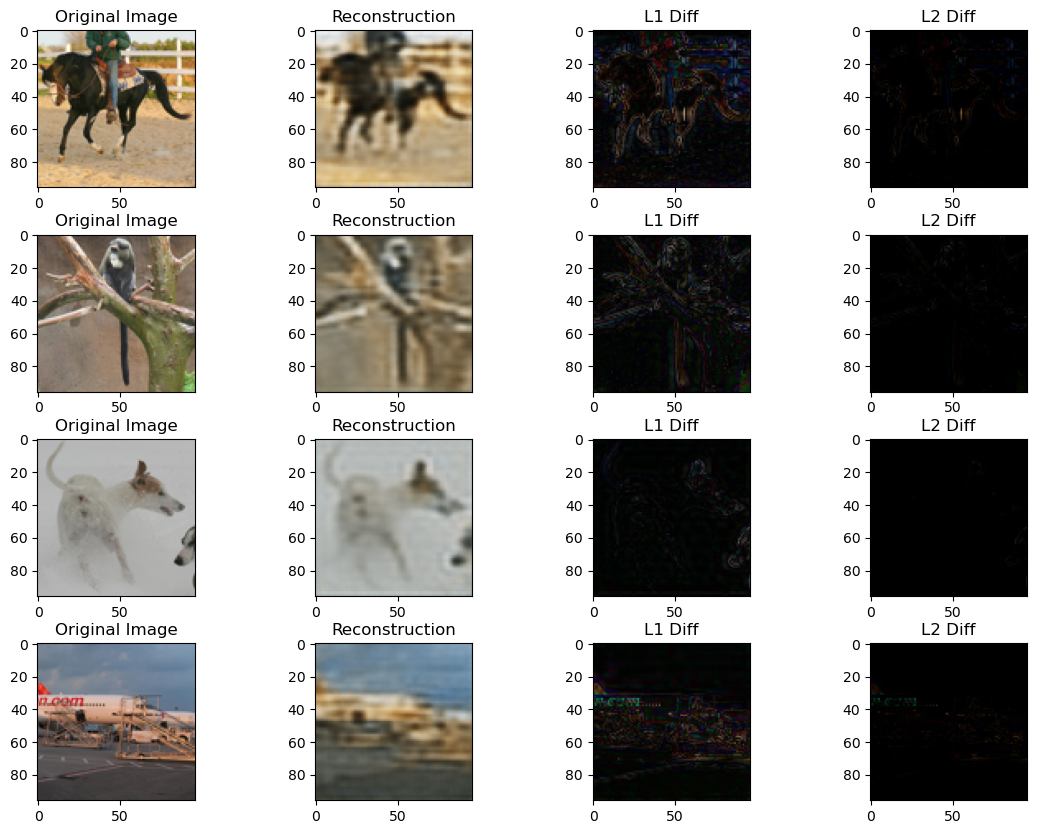

In [9]:
def load_model(model, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model {path} is loaded from epoch {checkpoint['epoch']} , loss {checkpoint['loss']}")
    return model


def get_reconstruction(autoencoder, img_batch):
    autoencoder.eval()
    img_batch = img_batch.to(device)
    reconstruction = autoencoder(img_batch)
    reconstruction = reconstruction.cpu().detach()
    return reconstruction


### START CODE HERE ### (≈ 8 line of code)
model = train_setup['model']
load_model(model, './best_autoencoder_min_val_loss.pth')

img_batch, _ = next(iter(load_data(4)[1]))
reconstructions = get_reconstruction(model, img_batch)

l1_diff = torch.abs(reconstructions - img_batch).permute(0, 2, 3, 1)
l2_diff = l1_diff ** 2
### END CODE HERE ###


# Plotting code is provided for you
batch = img_batch.shape[0]
plt.figure(figsize=(14, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for i in range(batch):
    plt.subplot(batch, 4, i * batch + 1)
    plt.title(f"Original Image")
    imshow(img_batch[i, ...])
    plt.subplot(batch, 4, i * batch + 2)
    imshow(reconstructions[i, ...])
    plt.title(f"Reconstruction")
    plt.subplot(batch, 4, i * batch + 3)
    plt.imshow(l1_diff[i, ...], cmap='gray')
    plt.title(f"L1 Diff")
    plt.subplot(batch, 4, i * batch + 4)
    plt.imshow(l2_diff[i, ...], cmap='gray')
    plt.title(f"L2 Diff")
plt.savefig("./figs/viz_reconstructions.png")
plt.show()

 ### Expected result

![im1](https://github.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/raw/main/exercises/week01/figs/viz_reconstructions_solution.png)

# Get the features from the trained encoder

In [10]:
# Provided
def get_features(model, dataloader):
    feats, labs = [], []
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        features = model(X)
        features = features.cpu().detach().flatten(start_dim=1)
        labels = y.cpu().detach()
        feats.append(features)
        labs.append(labels)
    f = torch.cat(feats, dim=0)
    l = torch.cat(labs, dim=0)
    return f, l


### START CODE HERE ### (≈ 8 line of code)
model, train_dl, val_dl = train_setup['model'], train_setup['train_dl'], train_setup['val_dl']
load_model(model, './best_autoencoder_min_val_loss.pth')

feats, labels = get_features(model, val_dl)
feats_ds = TensorDataset(feats, labels)

train_feats_ds, val_feats_ds = train_test_split(feats_ds, test_size=0.2)

train_feats_dl = DataLoader(train_feats_ds, batch_size=64)
val_feats_dl = DataLoader(train_feats_ds, batch_size=64)
### END CODE HERE ###

Model ./best_autoencoder_min_val_loss.pth is loaded from epoch 19 , loss 0.4317896733991802


# Linear evaluation: Probing

Linear evaluation or probing is a technique used in deep learning to evaluate the quality of the learned representations in pre-trained neural networks. The basic idea is to train a linear classifier on top of a pre-trained network and use it to perform a downstream task that can be different from the pre-training objective.

The pre-trained network is usually trained on a large dataset with the aim of learning useful representations that can be reused for other tasks. By training a linear classifier on top of the pre-trained network, we can evaluate how well the learned representations capture the relevant information for the new task. If the pre-trained network has learned useful representations, we should be able to achieve good performance on the new task without having to train the entire network from scratch.

Below you have to used the saved features and train a liner classifier on top on the training split of STL10.


```python
def train_one_epoch(model, optimizer, train_dl, device): pass
def validate(model, val_dl, device): pass
def linear_eval(model, optimizer, num_epochs, train_dl, val_dl, device): pass
```

In [11]:
### START CODE HERE ### (>20 line of code)
def train_one_epoch(model, optimizer, train_dl, criterion):
    correct = 0
    total = 0
    for X, y in tqdm(train_dl, desc='Train Batch', leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        output = model(X)
        loss = criterion(output, y)

        loss.backward()
        optimizer.step()

        total += y.size(0)
        correct += torch.sum(output.argmax(dim=1) == y)

    return correct / total


@torch.inference_mode()
def validate(model, val_dl):
    model.eval()
    correct = 0
    total = 0
    for X, y in tqdm(val_dl, desc='Validation Batch', leave=False):
        X, y = X.to(device), y.to(device)
        output = model(X)
        total += y.size(0)
        correct += torch.sum(output.argmax(dim=1) == y)

    return correct / total


def linear_eval(model, optimizer, num_epochs, train_dl, val_dl, criterion):
    for epoch in trange(num_epochs, desc='Epoch'):
        train_acc = train_one_epoch(model, optimizer, train_dl, criterion)
        val_acc = validate(model, val_dl)
        print(f'Epoch {epoch + 1}/{num_epochs}. Train Accuracy: {train_acc:.4f}  Val Accuracy: {val_acc:.4f}')


model = nn.Linear(feats.size(1), len(train_dl.dataset.classes))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 30

linear_eval(model, optimizer, num_epochs, train_feats_dl, val_feats_dl, criterion)
### END CODE HERE ###

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/30. Train Accuracy: 0.2236  Val Accuracy: 0.3133


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2/30. Train Accuracy: 0.2728  Val Accuracy: 0.3025


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3/30. Train Accuracy: 0.2806  Val Accuracy: 0.3730


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4/30. Train Accuracy: 0.3056  Val Accuracy: 0.3098


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5/30. Train Accuracy: 0.3211  Val Accuracy: 0.3422


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6/30. Train Accuracy: 0.3103  Val Accuracy: 0.3816


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7/30. Train Accuracy: 0.3505  Val Accuracy: 0.3548


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8/30. Train Accuracy: 0.3452  Val Accuracy: 0.3808


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9/30. Train Accuracy: 0.3512  Val Accuracy: 0.4000


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10/30. Train Accuracy: 0.3539  Val Accuracy: 0.3809


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 11/30. Train Accuracy: 0.3595  Val Accuracy: 0.3827


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 12/30. Train Accuracy: 0.3853  Val Accuracy: 0.3942


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 13/30. Train Accuracy: 0.3500  Val Accuracy: 0.3111


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 14/30. Train Accuracy: 0.3470  Val Accuracy: 0.3594


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 15/30. Train Accuracy: 0.3650  Val Accuracy: 0.3713


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 16/30. Train Accuracy: 0.3681  Val Accuracy: 0.4048


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 17/30. Train Accuracy: 0.3942  Val Accuracy: 0.3933


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 18/30. Train Accuracy: 0.4100  Val Accuracy: 0.3889


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 19/30. Train Accuracy: 0.3909  Val Accuracy: 0.3994


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20/30. Train Accuracy: 0.4080  Val Accuracy: 0.3923


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 21/30. Train Accuracy: 0.4139  Val Accuracy: 0.3875


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 22/30. Train Accuracy: 0.3761  Val Accuracy: 0.3892


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 23/30. Train Accuracy: 0.3986  Val Accuracy: 0.3942


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 24/30. Train Accuracy: 0.4014  Val Accuracy: 0.4208


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 25/30. Train Accuracy: 0.4058  Val Accuracy: 0.4034


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 26/30. Train Accuracy: 0.4081  Val Accuracy: 0.4156


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 27/30. Train Accuracy: 0.4206  Val Accuracy: 0.3995


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 28/30. Train Accuracy: 0.4258  Val Accuracy: 0.4259


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 29/30. Train Accuracy: 0.4355  Val Accuracy: 0.4197


Train Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 30/30. Train Accuracy: 0.4102  Val Accuracy: 0.4475


### Expected results (< 1 minute training)
Ep 29/30: Accuracy : Train:67.76 	 Val:46.95

# Conclusion and Bonus reads

That's the end of this exercise. If you reached this point, congratulations!

If you are interested to delve into this topic further, here are some links:

- [Recent Advances in Autoencoder-Based Representation Learning](https://arxiv.org/abs/1812.05069)
- [Understanding Representation Learning With Autoencoder ](https://neptune.ai/blog/representation-learning-with-autoencoder)
- [Learning continuous and data-driven molecular descriptors by translating equivalent chemical representations ](https://pubmed.ncbi.nlm.nih.gov/30842833/)
